# 2-D dynamical systems in neuroscience

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from scipy.integrate import odeint
from cycler import cycler
import seaborn as sns


palette = sns.color_palette("Set2")
plt.rc('axes', prop_cycle=cycler(color=palette))
plt.style.use(['science', 'grid', 'custom'])

## base model 
($I_{\text{Na,p}}+I_{K}$ model) 

$$
\begin{gather}
C\dot{V} = I - \underbrace{g_{\text{L}}(V - E_{\text{L}})}_{\text{leak current}} + \underbrace{g_{\text{Na}}m_{\infty}(V)(V - E_{\text{Na}})}_{\text{instantaneous sodium current}} - \underbrace{g_{\text{K}}\cdot n\cdot(V - E_{\text{K}})}_{\text{slow potassium current}} \\ \\
\dot{n} = \frac{n_{\infty}(V) - n}{\tau(V)}
\end{gather}
$$



In [4]:
# biophysical parameters

C = 1.0
I = 0.0

E_L_high = -80.0 #mV
E_L_low = -78 #mV
g_L = 8.0 # mS/cm^2

E_Na = 60.0 # mV
g_Na = 20.0 # mS/cm^2

E_K = -90.0 # mV
g_K = 10.0 # mS/cm^2

tau = 1.0 # ms

def boltzmann(V, V_half, k):
    return 1 / (1 + np.exp((V_half - V) / k))

m_inf = lambda V : boltzmann(V, -20.0, 15.0)
n_inf_high = lambda V : boltzmann(V, -25.0, 5.0)
n_inf_low = lambda V : boltzmann(V, -45.0, 5.0)

def dV_high(V, n, I):
    return (I - g_L*(V - E_L_high) - g_Na*m_inf(V)*(V - E_Na) - g_K*n*(V - E_K)) / C

def dn_high(V, n):
    return (n_inf_high(V) - n) / tau

def dV_low(V, n, I):
    return (I - g_L*(V - E_L_low) - g_Na*m_inf(V)*(V - E_Na) - g_K*n*(V - E_K)) / C

def dn_low(V, n):
    return (n_inf_low(V) - n) / tau


## nullclines

In [89]:

sorted(np.argwhere(np.abs(dV_grid) < 0.01)[:,1])

[168,
 175,
 180,
 181,
 188,
 190,
 197,
 210,
 212,
 219,
 224,
 225,
 227,
 234,
 251,
 263,
 265,
 274,
 275,
 276,
 282,
 299,
 307,
 349,
 385,
 397,
 409,
 435,
 440,
 511,
 539,
 591,
 599,
 656,
 735,
 772,
 887,
 898,
 919]

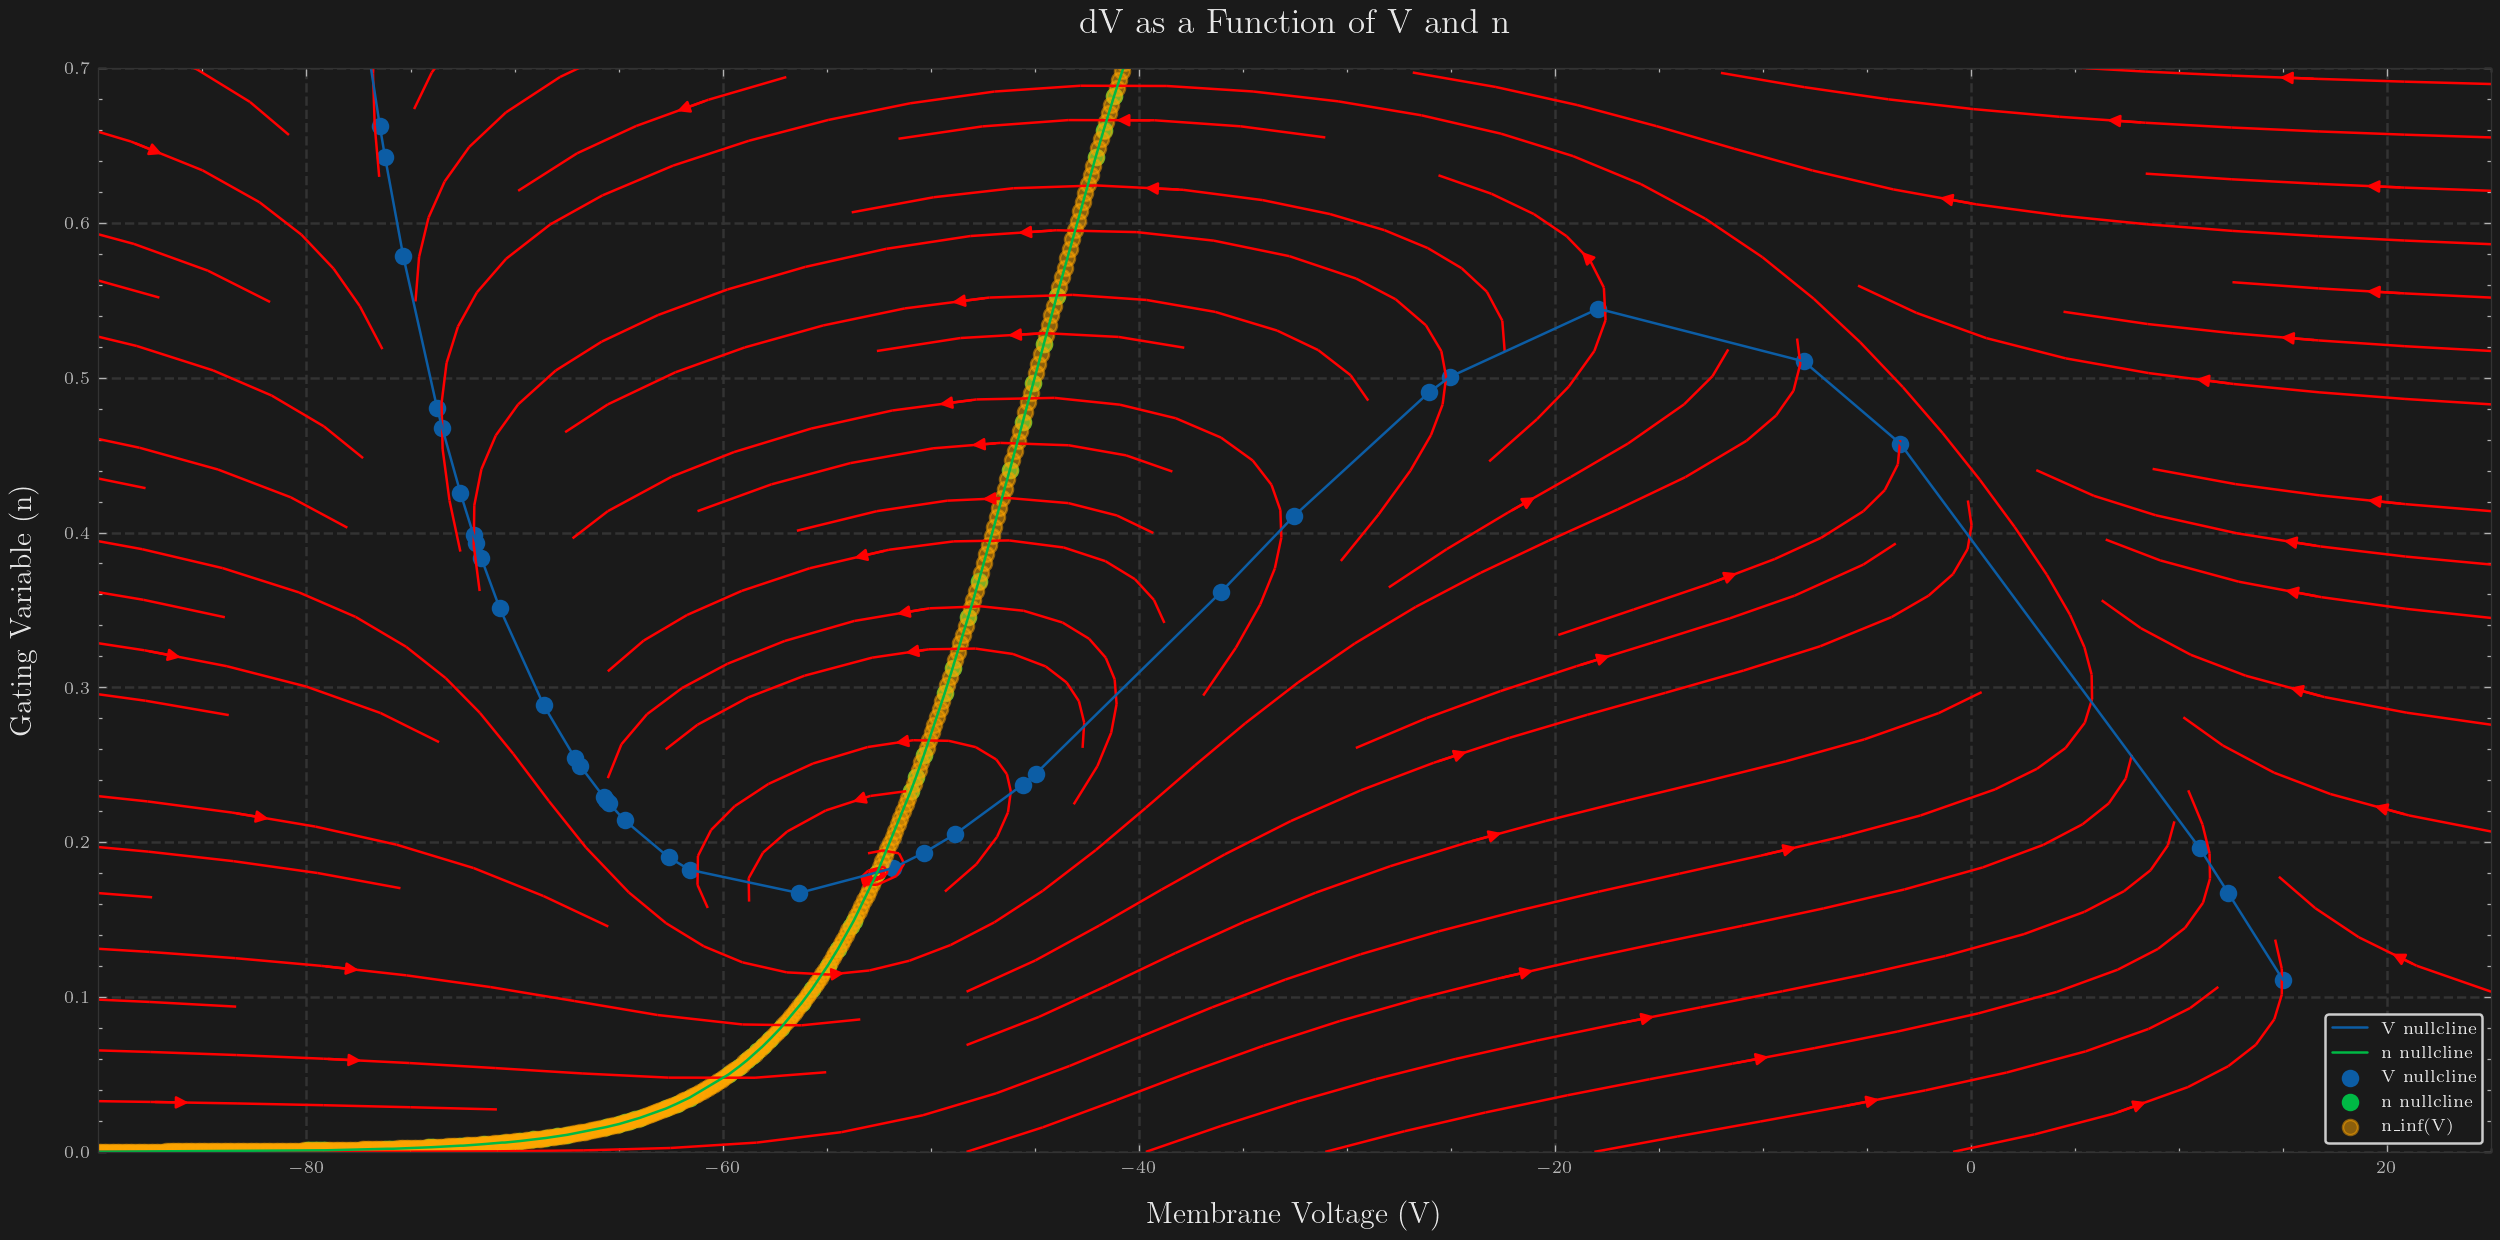

(39, 2)

In [103]:
V = np.linspace(-100, 25, 1000)
n = np.linspace(0, 1, 1000)

# n_nullcline_n = n[np.argwhere(np.abs(n_inf_low(V) - n) < 0.01).flatten()]
# n_nullcline_V = V[np.argwhere(np.abs(n_inf_low(V) - n) < 0.01).flatten()]

n_inf = n_inf_low(V)

V_grid, n_grid = np.meshgrid(V, n)

dV_grid = dV_low(V_grid, n_grid, I)
dn_grid = dn_low(V_grid, n_grid)

V_nullcline_indices = np.argwhere(np.abs(dV_grid) < 0.01)
n_nullcline_indices = np.argwhere(np.abs(dn_grid) < 0.0001)

sorted_V_nullcline_indices = V_nullcline_indices[np.argsort(V_nullcline_indices[:, 1])]

V_nullcline = np.column_stack((
    V[np.argwhere(np.abs(dV_grid) < 0.01)[:, 1]],
    n[np.argwhere(np.abs(dV_grid) < 0.01)[:, 0]]
))

n_nullcline = np.column_stack((
    V[np.argwhere(np.abs(dn_grid) < 0.0001)[:, 1]],
    n[np.argwhere(np.abs(dn_grid) < 0.0001)[:, 0]]
))  

plt.figure(figsize=(14, 7))
plt.streamplot(V_grid, n_grid, dV_grid, dn_grid, color='r', linewidth=1)

plt.plot(V[sorted_V_nullcline_indices[:, 1]], n[sorted_V_nullcline_indices[:, 0]], label="V nullcline")
plt.plot(V[n_nullcline_indices[:, 1]], n[n_nullcline_indices[:, 0]], label="n nullcline")

plt.scatter(V_nullcline[:,0], V_nullcline[:,1], label="V nullcline")
plt.scatter(n_nullcline[:, 0], n_nullcline[:,1], label="n nullcline")

plt.scatter(V, n_inf, label="n_inf(V)", color ='orange', alpha = 0.5)

plt.xlabel("Membrane Voltage (V)", fontsize=12)
plt.ylabel("Gating Variable (n)", fontsize=12)
plt.title("dV as a Function of V and n", fontsize=14)

plt.xlim(-90, 25)
plt.ylim(0, 0.7)

plt.legend()
plt.tight_layout()
plt.show()

V_nullcline.shape


## phase portraits

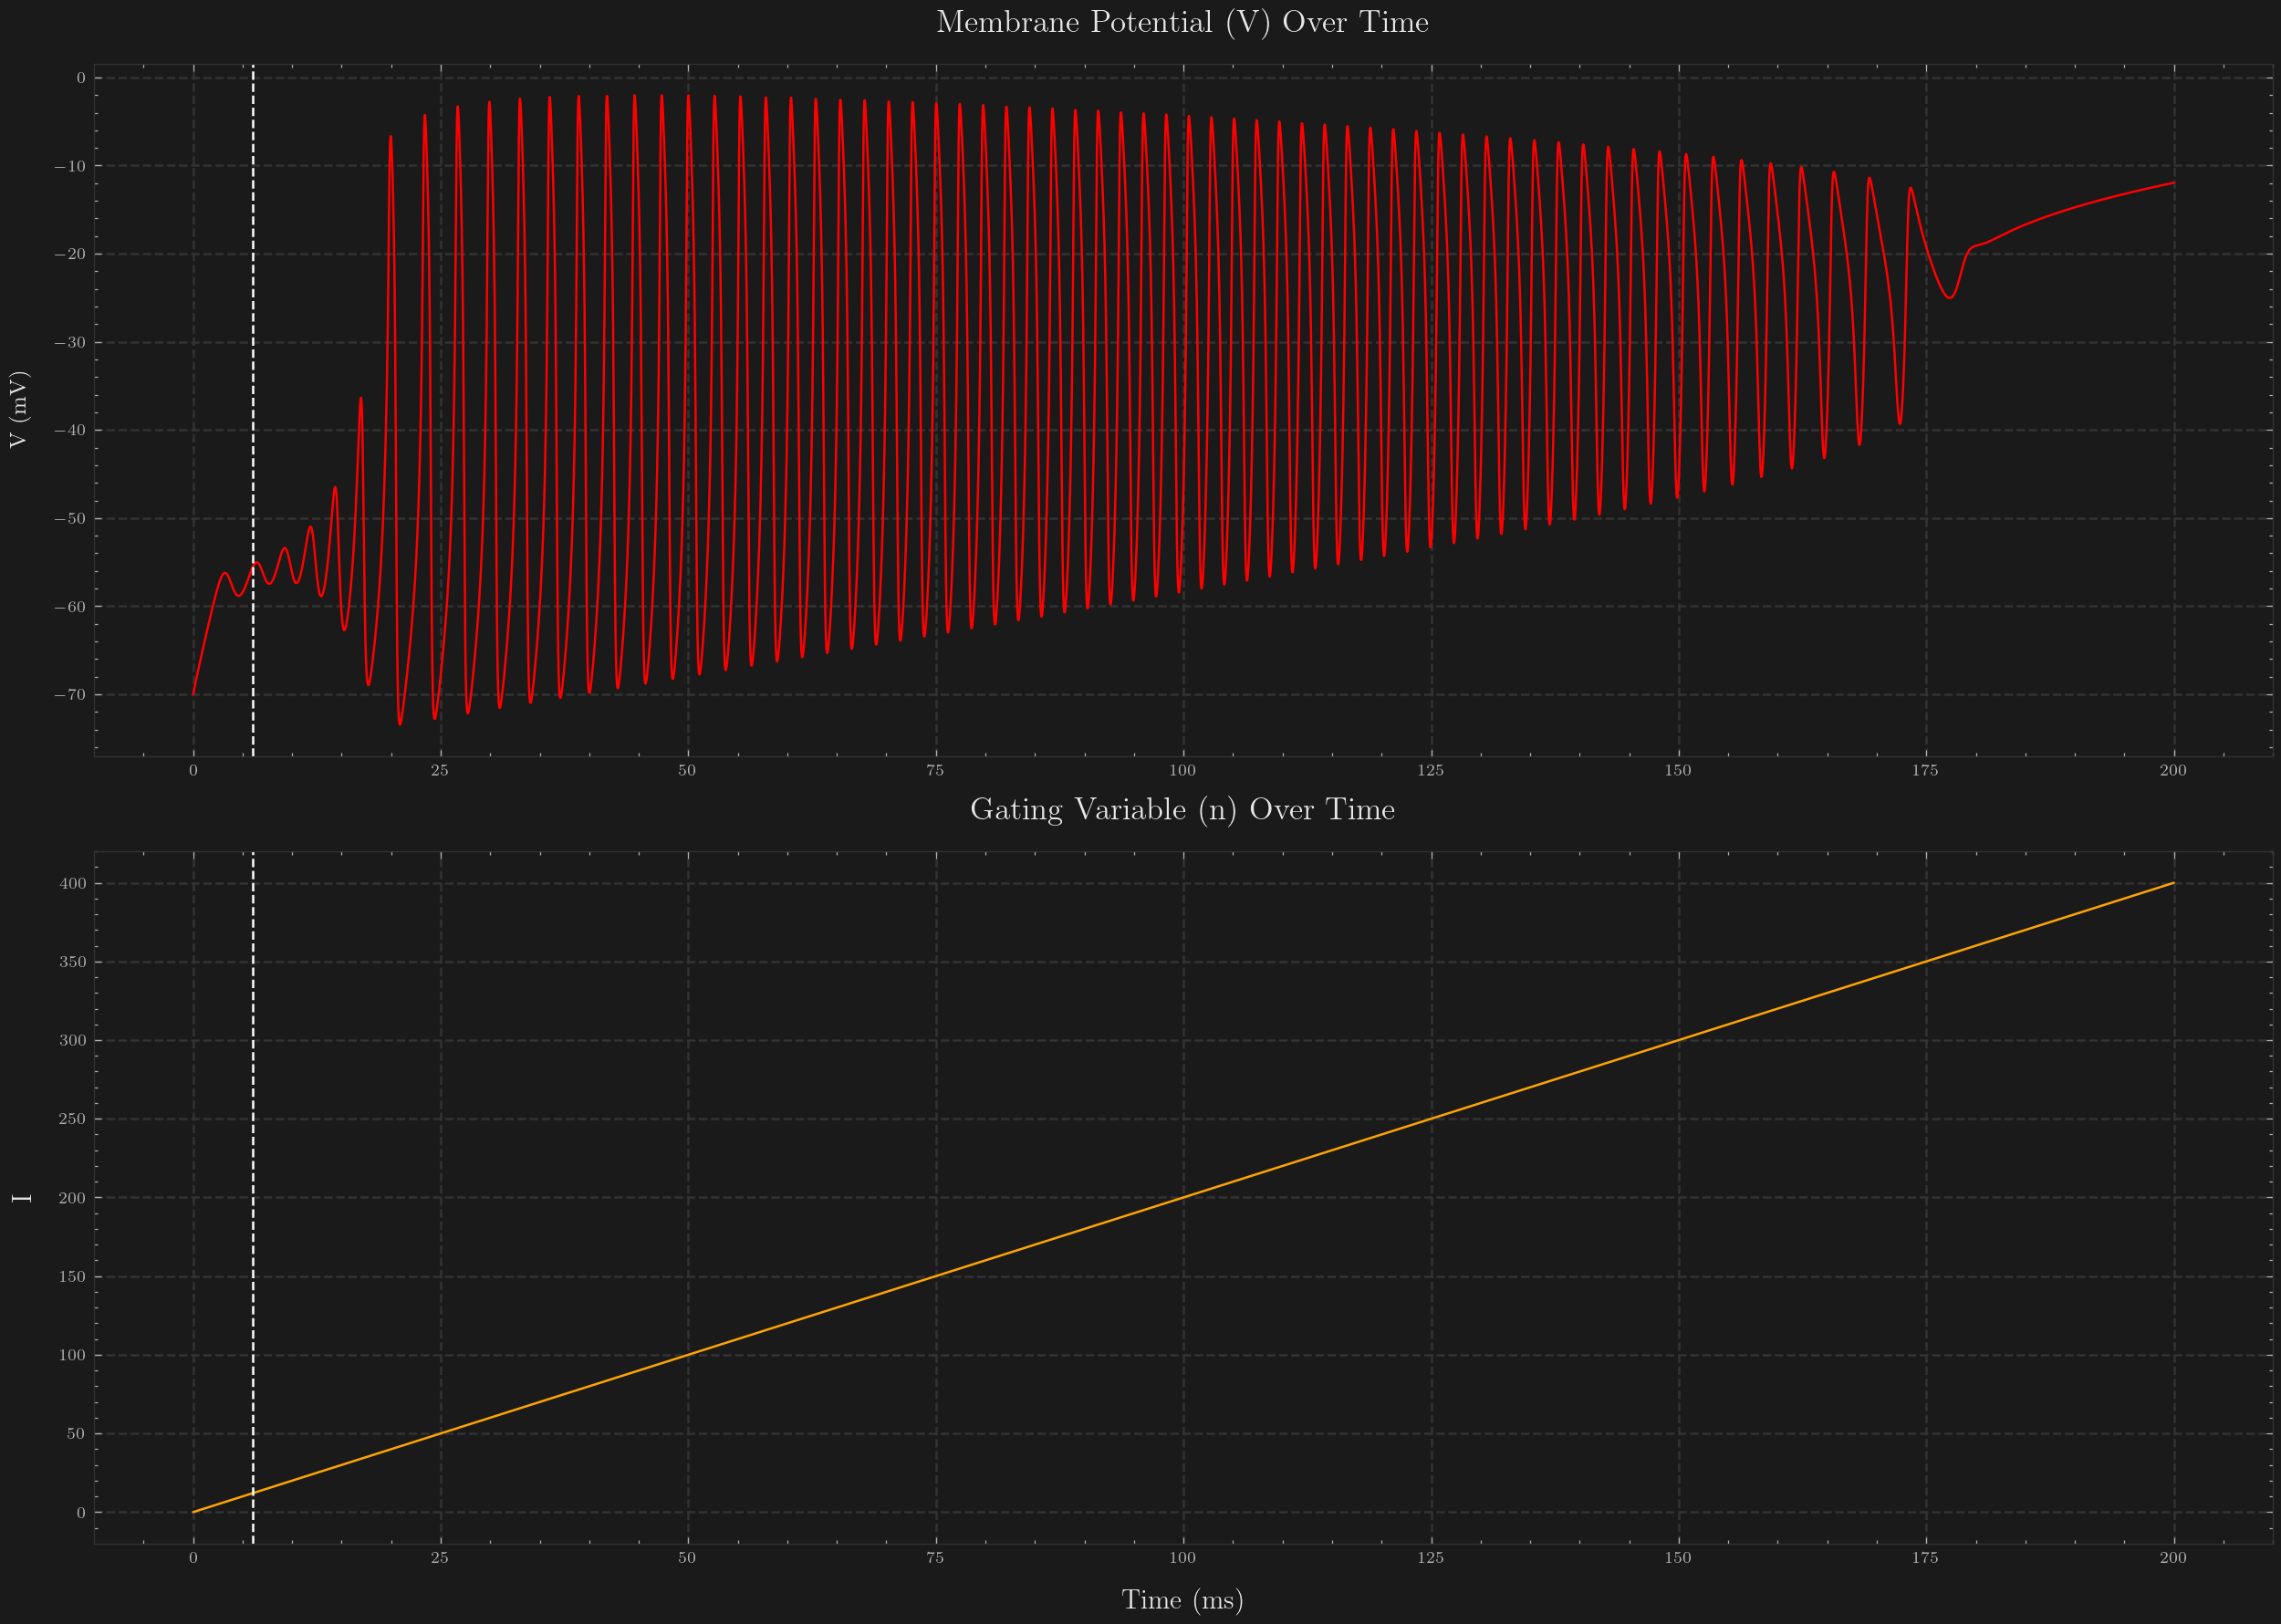

In [118]:
t = np.linspace(0, 200, 5000)
I = np.linspace(0, 400, 5000)

tau = 1.0

initial = (-70, 0.1)

def system(state, t, I_array, t_array):
    V, n = state
    I_value = np.interp(t, t_array, I_array)
    dVdt = dV_low(V, n, I_value)
    dndt = dn_low(V, n)
    return [dVdt, dndt]

solution = odeint(system, initial, t, args=(I, t))

V_values = solution[:, 0]
n_values = solution[:, 1]

plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
plt.plot(t, V_values, color='red')
plt.axvline(t[np.argwhere(np.abs(I - 12) < 0.01)[0][0]], color='white', linestyle='--')
plt.title("Membrane Potential (V) Over Time", fontsize=14)
plt.ylabel("V (mV)")

plt.subplot(2, 1, 2)
plt.plot(t, I, color='orange')
plt.axvline(t[np.argwhere(np.abs(I - 12) < 0.01)[0][0]], color='white', linestyle='--')
plt.title("Gating Variable (n) Over Time", fontsize=14)
plt.ylabel("I", fontsize=12)
plt.xlabel("Time (ms)", fontsize=12)

plt.tight_layout()
plt.show()


### bifurcation diagram (andronov-hopf bifurcation)

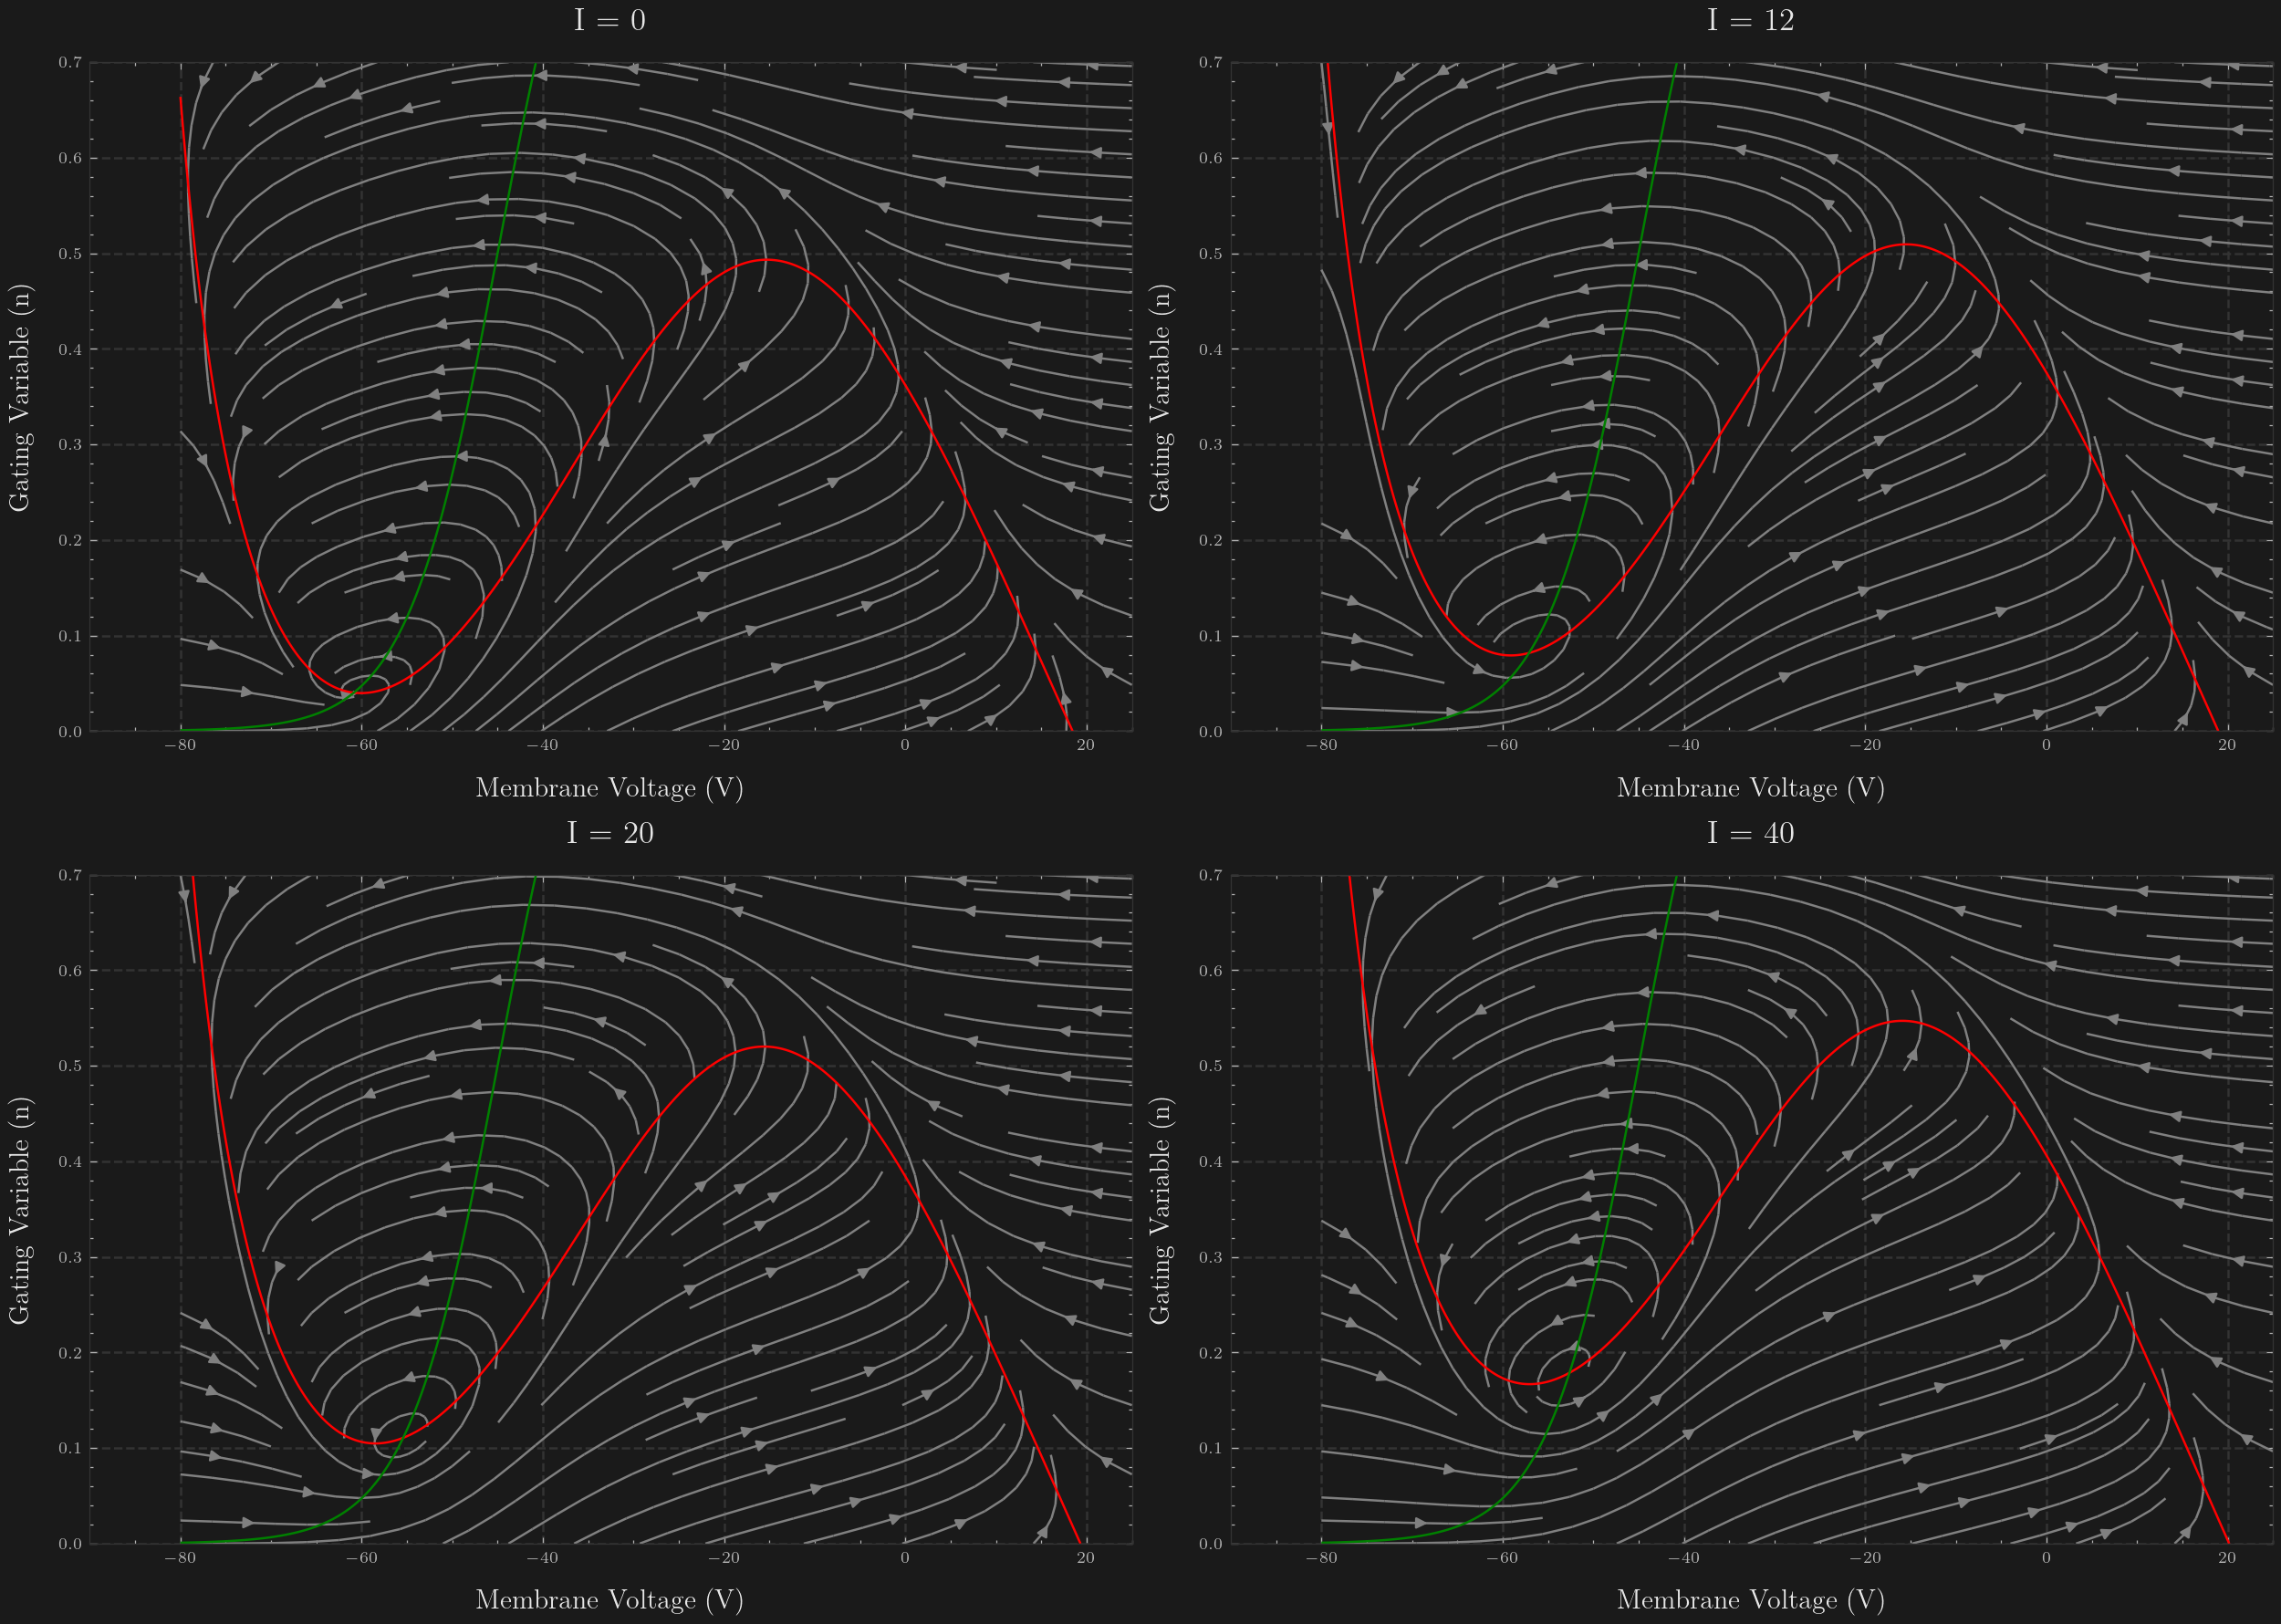

In [105]:
plt.figure(figsize=(14, 10))

V = np.linspace(-80, 25, 1000)
n = np.linspace(0, 0.7, 1000)

V_grid, n_grid = np.meshgrid(V, n)

for index, value in enumerate([0, 12, 20, 40]):
    I = value

    plt.subplot(2, 2, index + 1)

    dV_grid = dV_low(V_grid, n_grid, I)
    dn_grid = dn_low(V_grid, n_grid)
    
    plt.streamplot(V_grid, n_grid, dV_grid, dn_grid, color='grey', linewidth=1)
    plt.contour(V_grid, n_grid, dV_grid, levels=[0], colors='red')
    plt.contour(V_grid, n_grid, dn_grid, levels=[0], colors='green')

    plt.xlabel("Membrane Voltage (V)", fontsize=12)
    plt.ylabel("Gating Variable (n)", fontsize=12)
    plt.title(f"I = {I}", fontsize=14)
    plt.xlim(-90, 25)
    plt.ylim(0, 0.7)

plt.tight_layout()


(42,)

## fitzhugh nagumo model
The FitzHugh-Nagumo model is imitates the generation of action potentials in neurons. It is a simplified version of the Hodgkin-Huxley model with **cubic nullclines**. The model is given by the following set of differential equations:
<br>
$$
\dot{V} = V(a - V)(V - 1) - W + I
$$
$$
\dot{w} = bV - cW
$$

here $V$ mimics the membrane potential and $w$ represents the recovery variable.

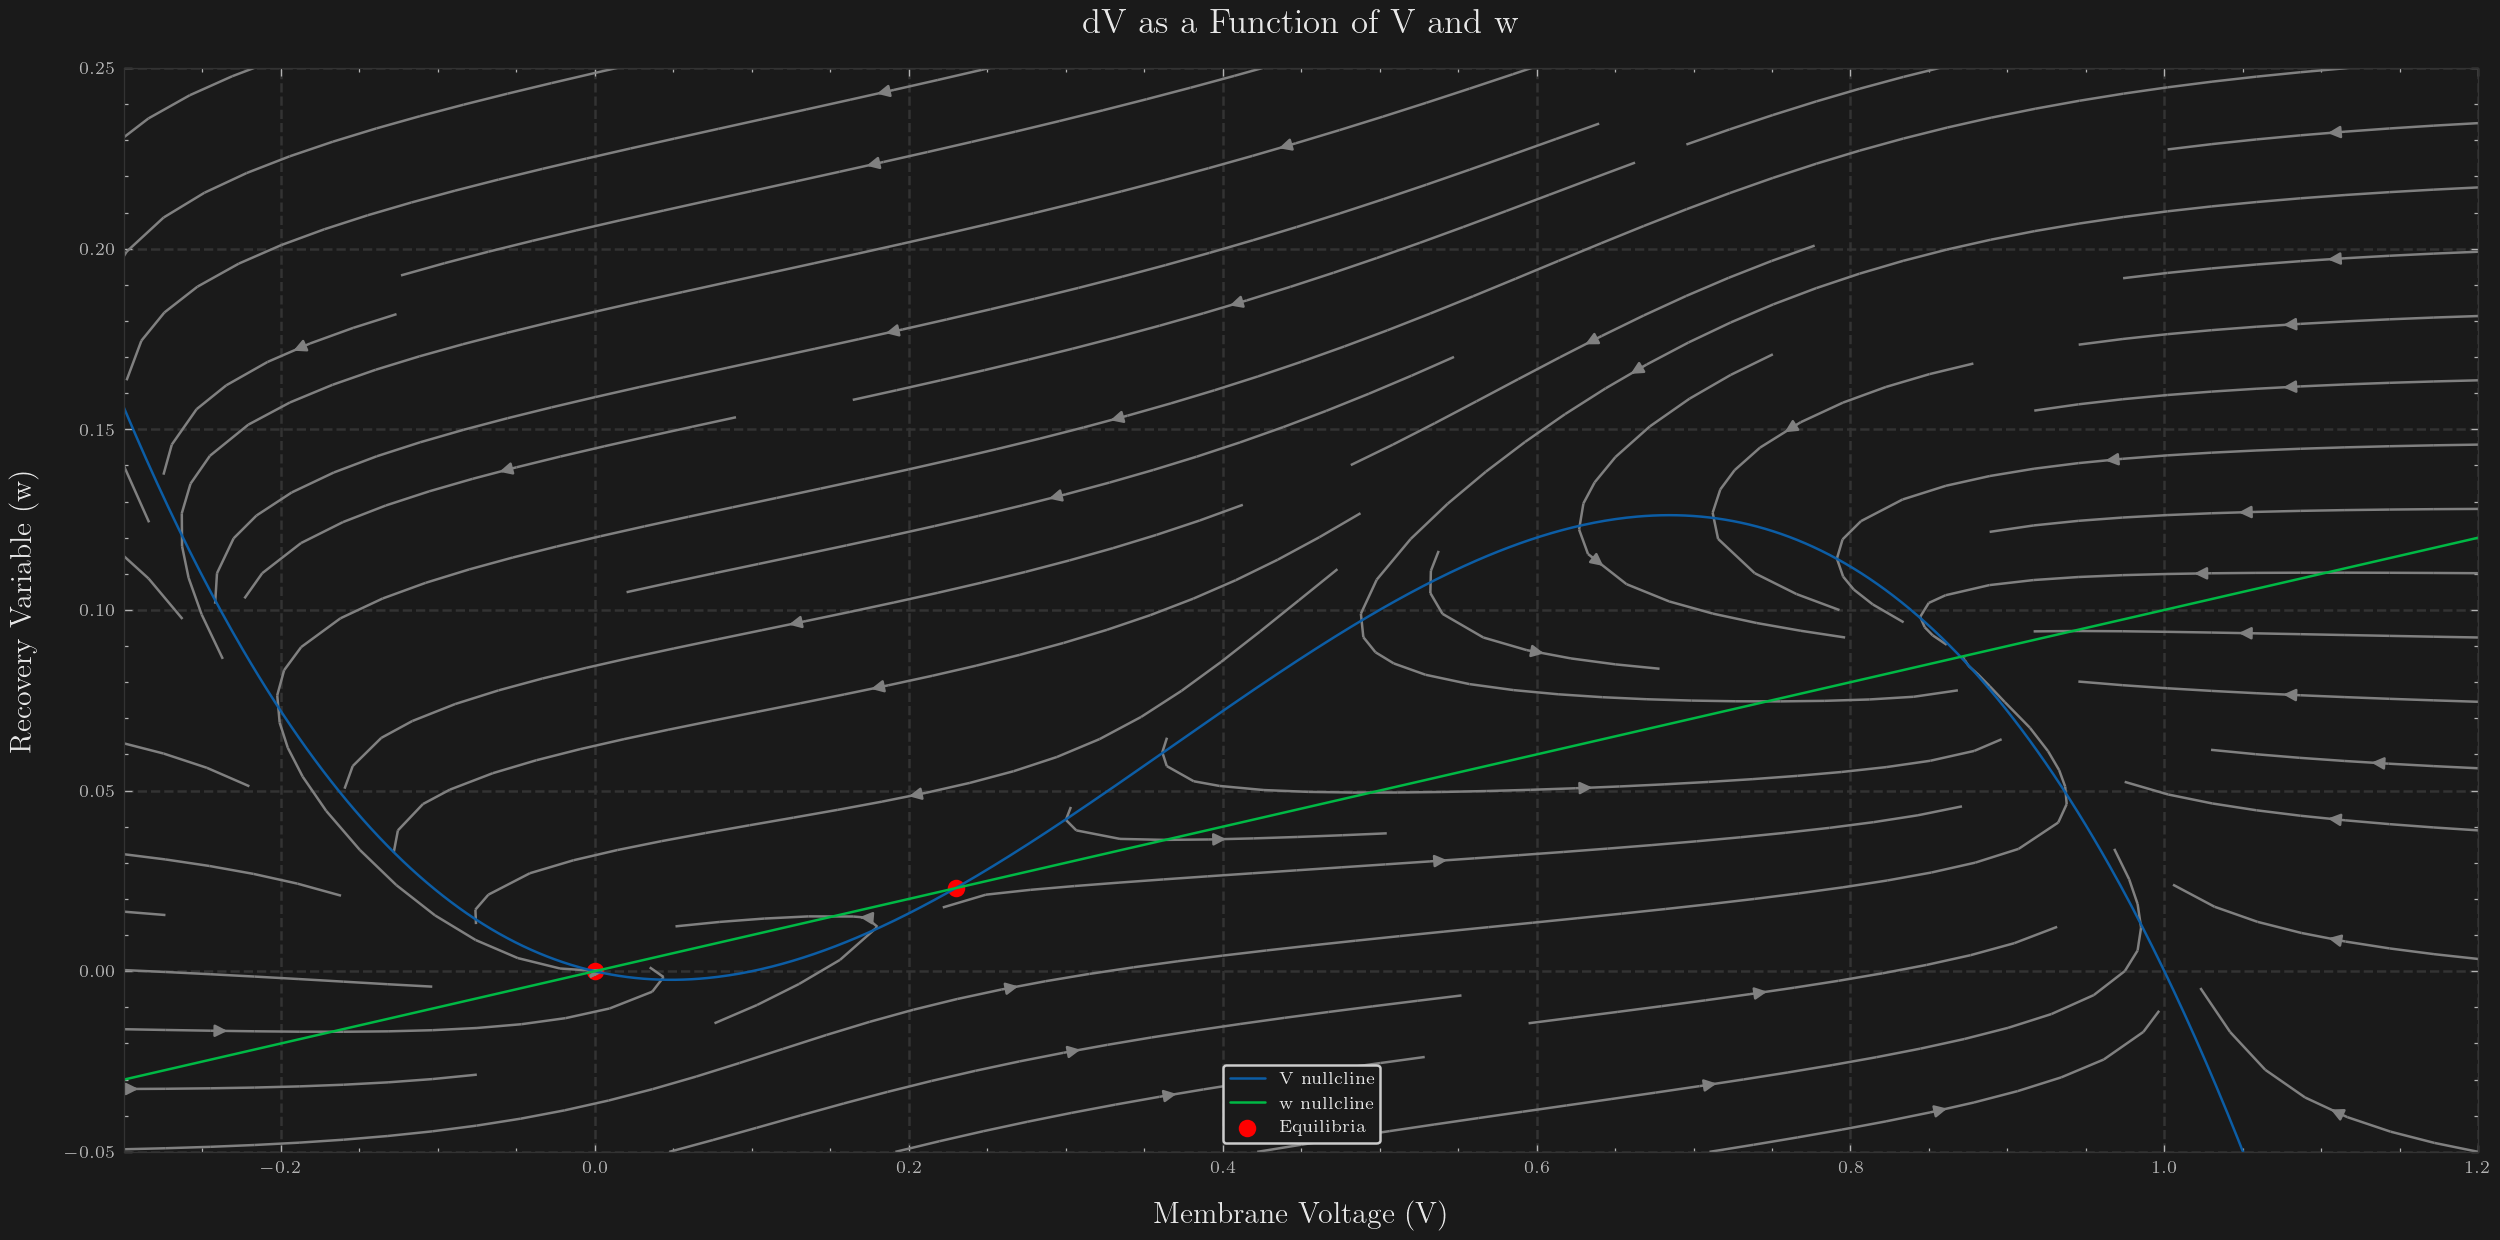

In [16]:
I = 0.0

dV = lambda V, w, I, a : V*(a - V)*(V - 1) - w + I
dw = lambda V, w, b, c : b*V - c*w

a = 0.1
b = 0.01
c = 0.1

V = np.linspace(-0.5, 1.2, 1000)
w = np.linspace(-0.05, 1, 1000)

V_grid, w_grid = np.meshgrid(V, w)

V_nullcline = V*(a - V)*(V - 1) + I
w_nullcline = b*V/c

dV_grid = dV(V_grid, w_grid, I, a)
dw_grid = dw(V_grid, w_grid, b, c)

equilibria = V[np.argwhere(np.abs(V_nullcline - w_nullcline) < 0.001).flatten()]
 

# plotting

plt.figure(figsize=(14, 7))
plt.streamplot(V_grid, w_grid, dV_grid, dw_grid, color='grey', linewidth=1, density=2)

plt.plot(V, V_nullcline, label="V nullcline")
plt.plot(V, w_nullcline, label="w nullcline")

plt.scatter(equilibria, equilibria*(a - equilibria)*(equilibria - 1), label="Equilibria", color='red')

plt.xlim(-0.3, 1.2)
plt.ylim(-0.05, 0.25)

plt.xlabel("Membrane Voltage (V)", fontsize=12)
plt.ylabel("Recovery Variable (w)", fontsize=12)

plt.title("dV as a Function of V and w", fontsize=14)
plt.legend()
plt.tight_layout()
